#### Part 1: Build a Basic Chatbot

In [ ]:
%%capture --no-stderr

In [ ]:
%pip install -qU langgraph langsmith langchain-ollama typing-extensions

In [19]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [8]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [9]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    base_url="http://ollama:11434",
    model="llama3.2",
    temperature=0
)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [10]:
llm.invoke('hey')

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-18T17:30:55.07444663Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 35957830891, 'load_duration': 34207030348, 'prompt_eval_count': 26, 'prompt_eval_duration': 936088000, 'eval_count': 8, 'eval_duration': 765680000}, id='run-f0bbc4d3-c7fb-4d1f-b57e-36f78f4eac38-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})

In [11]:
graph_builder.add_edge(START, "chatbot")

In [12]:
graph_builder.add_edge("chatbot", END)

In [13]:
graph = graph_builder.compile()

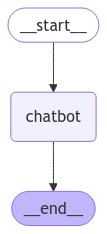

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  hey


Assistant: How can I assist you today?


User:  q


Goodbye!


#### Part 2: Enhancing the Chatbot with Tools

In [17]:
%%capture --no-stderr

UsageError: %%capture is a cell magic, but the cell body is empty.


In [18]:
%pip install -qU tavily-python langchain_community

Note: you may need to restart the kernel to use updated packages.


In [20]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY:  ········


In [24]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"}]

In [26]:
tool.name

'tavily_search_results_json'

In [25]:
from typing import Annotated

from langchain_ollama import ChatOllama
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOllama(
    base_url="http://ollama:11434",
    model="llama3.2",
    temperature=0
)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [28]:
llm_with_tools.invoke('what is the value of pi')

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-18T18:11:51.073394419Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'value of pi'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 28062543097, 'load_duration': 17965072759, 'prompt_eval_count': 192, 'prompt_eval_duration': 7877997000, 'eval_count': 23, 'eval_duration': 2214548000}, id='run-56453f19-1fe6-4afb-b699-77cafa889c80-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'value of pi'}, 'id': '13a373ff-17c5-4c67-b8a0-e37f18e601a7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 192, 'output_tokens': 23, 'total_tokens': 215})

In [27]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [29]:
from typing import Literal

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

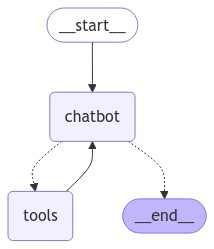

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  hey


Assistant: 
Assistant: [{"url": "https://www.oxfordlearnersdictionaries.com/definition/english/hey", "content": "Hey is an exclamation that can be used to attract attention, express interest, surprise or anger, or to say hello or goodbye. Learn how to use hey in different contexts and idioms with pictures and pronunciation."}, {"url": "https://www.collinsdictionary.com/us/dictionary/english/hey", "content": "Hey is an interjection used to attract attention, express surprise, interest, or annoyance, or to greet someone. Learn how to use hey in different contexts and regions, and see synonyms and related terms."}]
Assistant: The term "hey" can be used as an exclamation to attract attention, express interest, surprise, or anger, or to say hello or goodbye. It's a versatile word that can be used in various contexts and is widely recognized across different regions. If you're looking for alternative ways to express yourself, there are also synonyms like "hi," "hello," or "greetings" that ca

User:  why sky is blue?


Assistant: 
Assistant: [{"url": "https://www.scientificamerican.com/article/why-is-the-sky-blue/", "content": "The acceleration of the charged particles is proportional to the square of the frequency, and the intensity of scattered light is proportional to the square of this acceleration. The longer distance that the sunlight travels through the atmosphere when it is on the horizon amplifies the effect--there are more opportunities for blue light to be scattered than when the sun is overhead. More of the sunlight entering the atmosphere is blue than violet, however, and our eyes are somewhat more sensitive to blue light than to violet light, so the sky appears blue.\n To understand why the sky is blue, we need to consider the nature of sunlight and how it interacts with the gas molecules that make up our atmosphere.\n For many purposes, sunlight can be thought of as an electromagnetic wave that causes the charged particles (electrons and protons) inside air molecules to oscillate up an

User:  q


Goodbye!


#### Part 3: Adding Memory to the Chatbot

In [33]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [34]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(
    base_url="http://ollama:11434",
    model="llama3.2",
    temperature=0
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [35]:
graph = graph_builder.compile(checkpointer=memory)

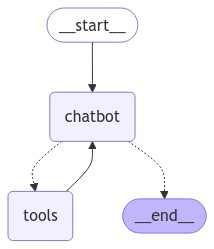

In [36]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [37]:
config = {"configurable": {"thread_id": "1"}}

In [43]:
user_input = "Hi! My name is Ravi."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! My name is Ravi.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (efb739d0-1ee6-444d-aa80-1a640731ca9f)
 Call ID: efb739d0-1ee6-444d-aa80-1a640731ca9f
  Args:
    query: Ravi
================================= Tool Message =================================
Name: tavily_search_results_json

HTTPError('400 Client Error: Bad Request for url: https://api.tavily.com/search')
================================== Ai Message ==================================

It seems like the Tavily search API is still not responding. Let me try a different approach.

Since I don't have any specific information about you, Ravi, could you please tell me something about yourself? What are your interests or hobbies? This might help me provide a more personalized response.


In [44]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (cbb9411d-23b6-4d58-a4df-3011e812fd29)
 Call ID: cbb9411d-23b6-4d58-a4df-3011e812fd29
  Args:
    query: Ravi
================================= Tool Message =================================
Name: tavily_search_results_json

HTTPError('400 Client Error: Bad Request for url: https://api.tavily.com/search')
================================== Ai Message ==================================

I remember that you mentioned your name is Ravi earlier, but the Tavily search API isn't responding. Let me try to recall our conversation.

You initially asked "Hi there! My name is Ravi." and I responded with an empty JSON object, indicating that I couldn't find any relevant information about a person named Ravi at the time.

If you'd like to continue the conversation or ask a new que

In [46]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (d37d5b67-82f5-43f0-aefa-4cfbb444fc83)
 Call ID: d37d5b67-82f5-43f0-aefa-4cfbb444fc83
  Args:
    query: current events
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.nytimes.com/spotlight/learning-current-events", "content": "Supported by\nCurrent Events\nResources for teaching about current events using New York Times content\nResources for teaching about current events using New York Times content\nAdvertisement\nSpecial End-of-Year 2023 News Quiz for Students\nSee what you remember about this extraordinary year by taking our special 2023 news quiz.\n By Michael Gonchar\nAdvertisement\nSign Up for Weekly Emails\nA weekly collection of lesson plans, writing prompts and activiti

In [48]:
# snapshot = graph.get_state(config)
# snapshot

#### Part 4: Human-in-the-loop

In [49]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(
    base_url="http://ollama:11434",
    model="llama3.2",
    temperature=0
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [50]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [51]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8fc59484-e53d-4ec9-8052-3f84c5da5606)
 Call ID: 8fc59484-e53d-4ec9-8052-3f84c5da5606
  Args:
    query: LangGraph


In [52]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [53]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': '8fc59484-e53d-4ec9-8052-3f84c5da5606',
  'type': 'tool_call'}]

In [54]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8fc59484-e53d-4ec9-8052-3f84c5da5606)
 Call ID: 8fc59484-e53d-4ec9-8052-3f84c5da5606
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with examples and code snippets."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to build agent and multi-agent workfl